# Mathematical Modelling for Sustainable Development
## Coursework Submission 2025
### Serena Farrelly

Question 2: Tipping points and the Greenland ice sheet

Modelling the interplay between global temperatures and albedo affect to predict the melting of the greenland icesheet.


### Modelling Assumptions

- parabolic ice sheet cross section

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

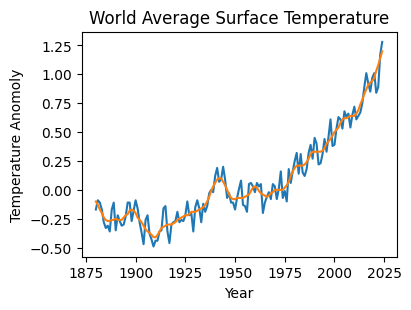

In [10]:
with open("temperature.txt", "r") as file:
    lines = file.readlines()  # Read all lines into a list

# get rid of initial headers
lines = lines[5:len(lines)]

# Process each line
data = [line.strip().split() for line in lines]  # Removes '\n' and splits by space
processed_data = [[int(line[0]), float(line[1]), float(line[2])] for line in data]

# putting into a np array
NASAtemp = np.array(processed_data)
# print(np.shape(NASAtemp))

fig = plt.figure(figsize=(9,3))
ax1 = fig.add_axes([0.10, 0.15, 0.35, 0.75])
ax1.plot(NASAtemp[:,0], NASAtemp[:,1])
ax1.plot(NASAtemp[:,0], NASAtemp[:,2])
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature Anomoly')
ax1.set_title('World Average Surface Temperature')
plt.show()

[0.001      0.00104656 0.00109246 0.0011377  0.0011823  0.00122627
 0.00126961 0.00131234 0.00135445 0.00139598 0.00143691 0.00147726
 0.00151705 0.00155627 0.00159493 0.00163306 0.00167065 0.00170772
 0.00174428 0.00178032 0.00181587 0.00185092 0.00188549 0.00191957
 0.00195318 0.00198632 0.002019   0.00205122 0.00208299 0.00211432
 0.00214522 0.00217568 0.00220572 0.00223533 0.00226454 0.00229334
 0.00232174 0.00234974 0.00237736 0.00240459 0.00243145 0.00245793
 0.00248405 0.0025098  0.0025352  0.00256025 0.00258496 0.00260933
 0.00263336 0.00265706 0.00268045 0.00270351 0.00272626 0.0027487
 0.00277084 0.00279269 0.00281424 0.0028355  0.00285648 0.00287717
 0.0028976  0.00291776 0.00293765 0.00295728 0.00297666 0.00299578
 0.00301466 0.0030333  0.0030517  0.00306986 0.00308779 0.00310549
 0.00312296 0.00314021 0.00315723 0.00317403 0.00319061 0.00320698
 0.00322314 0.0032391  0.00325485 0.0032704  0.00328575 0.0033009
 0.00331587 0.00333064 0.00334523 0.00335964 0.00337386 0.003387

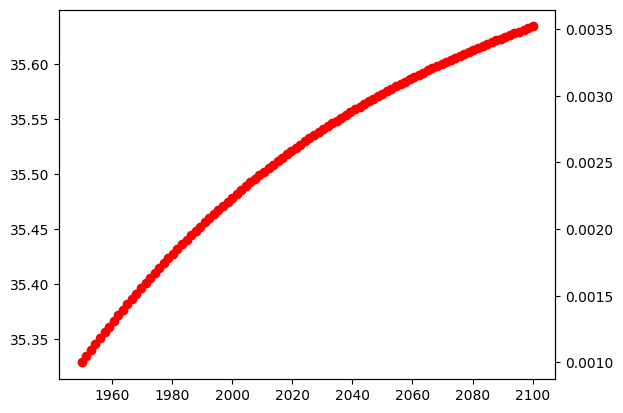

In [61]:
# we also want how betastar changes with time
# assuming emissions increase linearly
gamma = 0.001           # rate of linear emissions (to be calibrated)
def get_E(t, gamma):
    E_1950 = 5.2e9      # CO2 emissions in 1950 (tonnes)
    E = gamma*(t-1950)+E_1950
    return E

start_year = 1950
end_year = 2100
t = np.linspace(start_year, end_year, 100)
# E_arr = np.array([])
E_arr = get_E(t, gamma)

## need to check that this is ok to remain as annual emissions rather than cumulative CO2 levels

# how emissions relate to CO2 air density
def drho_dt(E, rho):
    kappa = 0.005           # coefficient (to be calibrated)
    t_CO2 = 100             # life span of CO2 in atmosphere (years)
    rho_1950 = 315          # technically 1959 (ppm)
    return kappa*E - (1/t_CO2)*(rho-rho_1950)

rho_0 = 315             # initial condition
# integrate to find the CO2 air density at current emissions level (for the year)
rho = solve_ivp(drho_dt, [start_year, end_year], [rho_0], t_eval=t)
# print(rho)

# how CO2 air density relates to betastar
G = (1/315)*0.001               # proportionality constant (to be calibrated)
# calibration philosophy: they be smol (<0.1)
betastar = G*rho.y[0]          # array of man-made greenhouse effect values

print(betastar)

def T(betastar, T_0):
    alpha = 0.3         # albedo effect
    beta = 0.4          # greenhouse effect
    sigma = 5.67e-8     # Stefan-Boltzmann constant
    R_in = 340          # incoming solar energy (W/m^2)
    d_T = (((1-alpha)*R_in) / ((1-(beta+betastar))*sigma))**0.25 - T_0
    return d_T


T_0 = 273-19               # initial condition
d_T_arr = T(betastar, T_0)
# print(d_T_arr)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t,d_T_arr)
ax2.plot(t,betastar, "ro-")
plt.show()

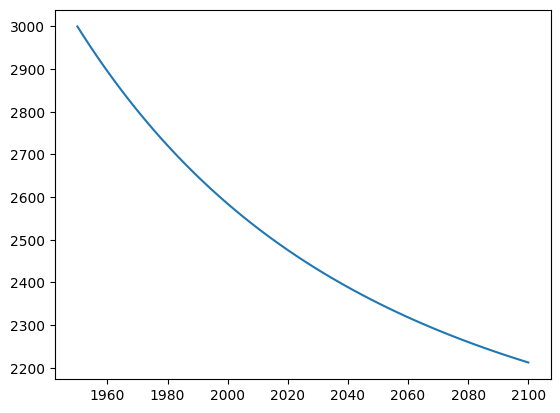

In [66]:
# we need to feed these temperatures into melting term of the ice sheet height model
# lets get some shit down

# rate of change of height of ice sheet
def dh_dt(d_T, h):
    P = 4           # precipitation rate (m/yr)
    r = 1           # rate of melting (m/yr)
    T_0 = 273-19    # pre-industrial surface temp (K)
    h_f = 1         # characteristic length, altitude above which the ice won't melt
    F = 1           # rate of flow of ice sheet into the sea

    dh_dt = P - (r*(T_0+d_T))/(h+h_f)-(F*h)
    if h <= 0 and dh_dt < 0:
        dh_dt = 0
    return dh_dt


h_0 = 3000             # initial condition
# integrate to find the CO2 air density at current emissions level (for the year)
h_arr = solve_ivp(dh_dt, [min(d_T_arr), max(d_T_arr)], [h_0], t_eval=d_T_arr)

plt.plot(t,h_arr.y[0])
plt.show()